#  Predict canopy height using TERN LiDAR and DEA satellite data


## Import libraries

In [1]:
# !pip install lightgbm
# !pip install shap

In [2]:
import odc.stac
import pystac_client
import xarray as xr
import numpy as np
import rioxarray as rxr
import geopandas as gpd
import matplotlib.pyplot as plt

from odc.geo import BoundingBox
from odc.geo.xr import assign_crs
from odc.stac import stac_load

import shap
import lightgbm as lgb
from dea_tools.classification import sklearn_flatten, predict_xr
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error

from odc.algo import geomedian_with_mads
from dea_tools.dask import create_local_dask_cluster

## Start dask client

In [3]:
client = create_local_dask_cluster(return_client=True)

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Workers: 1
Total threads: 7,Total memory: 59.21 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41979,Workers: 1
Dashboard: /user/chad.burton@ga.gov.au/proxy/8787/status,Total threads: 7
Started: Just now,Total memory: 59.21 GiB
Comm: tcp://127.0.0.1:35739,Total threads: 7
Dashboard: /user/chad.burton@ga.gov.au/proxy/35789/status,Memory: 59.21 GiB
Nanny: tcp://127.0.0.1:39003,


## Analysis Parameters

In [4]:
# Set a start and end date
start_date = "2024-01-01"
end_date = "2024-12-31"

# data loading params
crs="EPSG:3577"
resolution=10
measurements=[
 'nbart_red',
 'nbart_blue',
 'nbart_green',
 'nbart_nir_1',
 'nbart_nir_2',
 'nbart_swir_2',
 'nbart_swir_3',
 'nbart_red_edge_1',
 'nbart_red_edge_2',
 'nbart_red_edge_3',
]

masking_band = 'oa_s2cloudless_mask'

## Open Canopy height data

Already processed this in another notebook

In [5]:
chm = rxr.open_rasterio('chm.tif').squeeze().drop_vars('band')

## Search DEA STAC Catalog for S2 data

Using the boundary box of the canopy-height data

In [6]:
bbox=chm.odc.geobox.to_crs('EPSG:4326').boundingbox

In [7]:
#search catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

query = catalog.search(
    bbox=bbox,
    collections=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    datetime=f"{start_date}/{end_date}"
)

items = list(query.items())
print('items =', len(items))

items = 72


## Load Sentinel-2 images

In [8]:
ds = odc.stac.load(
    items,
    bands=measurements+[masking_band],
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox,
    chunks={},
)

clear = xr.where(ds['oa_s2cloudless_mask'] == 1, True, False)
ds = ds.drop_vars(masking_band).where(clear)
ds

<xarray.Dataset> Size: 5MB
Dimensions:           (time: 72, y: 46, x: 35)
Coordinates:
  * y                 (y) float64 368B -2.399e+06 -2.399e+06 ... -2.399e+06
  * x                 (x) float64 280B 1.273e+05 1.273e+05 ... 1.277e+05
    spatial_ref       int32 4B 3577
  * time              (time) datetime64[ns] 576B 2024-01-03T01:23:22.053901 ....
Data variables:
    nbart_red         (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_blue        (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_green       (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_nir_1       (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_nir_2       (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_swir_2      (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_swir_3      (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_red_edge_1  (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_red_edge_2  (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>
    nbart_red_edge_3  (time, y, x) float32 464kB dask.array<chunksize=(1, 46, 35), meta=np.ndarray>

## Calculate Geomedian

In [9]:
%%time
s2_gm = geomedian_with_mads(
    ds,
    reshape_strategy='yxbt', #'yxbt' if data is larger than RAM
    compute_mads=True # True if you want triple MADs
)

# bring into memory
s2_gm = assign_crs(s2_gm.load(), crs=crs)
s2_gm = s2_gm.drop_vars('count')

/env/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


CPU times: user 16.9 s, sys: 1.27 s, total: 18.2 s
Wall time: 3min 14s


## Reproject canopy height

So it matches the projection of our sentinel-2 data

In [10]:
chm = chm.odc.reproject(how=s2_gm.odc.geobox, resampling='average', dst_nodata=np.nan)

And mask out any NaN pixels from the GM

In [11]:
chm_mask = ~np.isnan(chm)
s2_gm = s2_gm.where(chm_mask)

### Plot

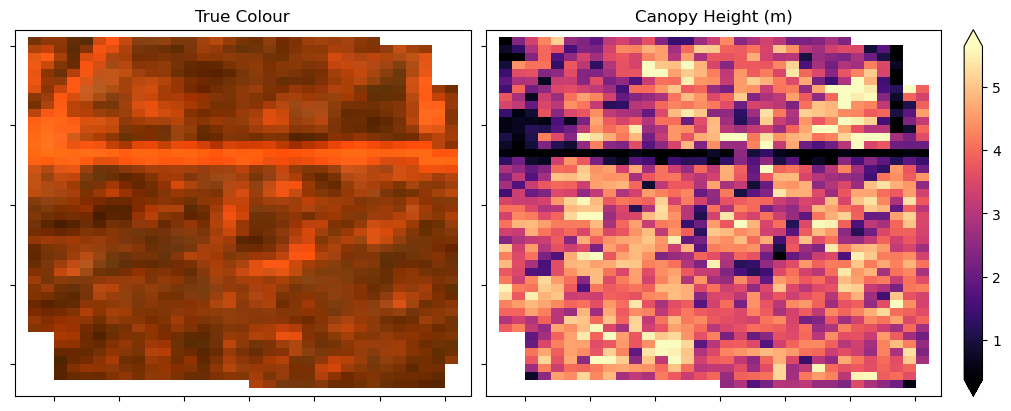

In [12]:
fig,ax=plt.subplots(1,2, figsize=(10,4), sharey=True, layout='constrained')
s2_gm[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(ax=ax[0], robust=True, add_labels=False)
chm.plot.imshow(ax=ax[1], robust=True, cmap='magma', add_labels=False)
ax[0].set_title('True Colour')
ax[1].set_title('Canopy Height (m)')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);

## Fit a canopy height model to the satellite data

In [14]:
X = sklearn_flatten(s2_gm)
y = sklearn_flatten(chm)

# Mask out NaNs
mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
X = X[mask]
y = y[mask]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define LightGBM regressor
model = lgb.LGBMRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=-1,     
    num_leaves=31,
    n_jobs=-1,
    random_state=42,
    verbose=-1
)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

print(f"R²: {r2_score(y_test, y_pred):.2f}")
print(f"RMSE: {root_mean_squared_error(y_test, y_pred):.2f}")

R²: 0.47
RMSE: 0.84


### Feature Importance

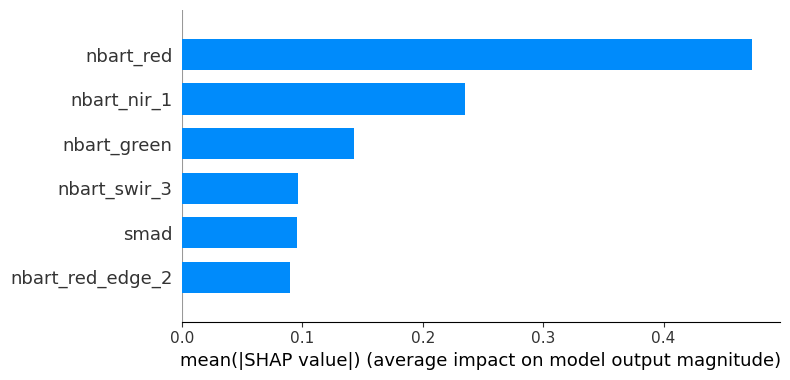

In [15]:
# SHAP explainers can work with tree-based models like RandomForest
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
feature_names = list(s2_gm.data_vars)

#Bar plot of mean absolute SHAP values
shap.summary_plot(shap_values, X, feature_names=feature_names, max_display=6, plot_type="bar")

### Predict on the same region

In [16]:
y_pred_xr = predict_xr(model, s2_gm, clean=True)
y_pred_xr = y_pred_xr.where(chm_mask)

predicting...


### Plot

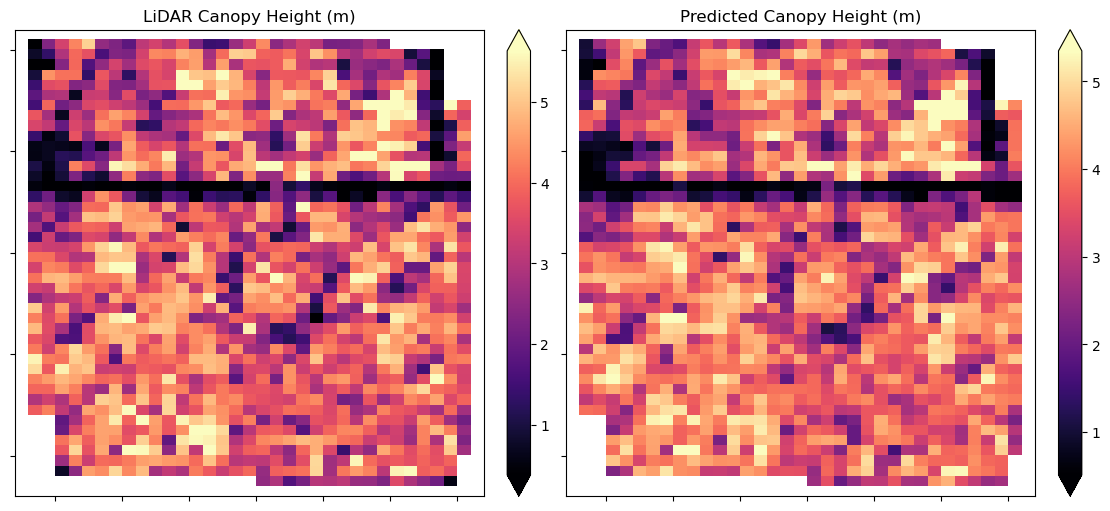

In [17]:
fig,ax=plt.subplots(1,2, figsize=(11,5), sharey=True, layout='constrained')

chm.plot.imshow(ax=ax[0], robust=True, cmap='magma', add_labels=False)
y_pred_xr['Predictions'].plot.imshow(ax=ax[1], robust=True, cmap='magma', add_labels=False)
ax[0].set_title('LiDAR Canopy Height (m)')
ax[1].set_title('Predicted Canopy Height (m)')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);

## Predict on a new region

Load data from a similar bioclimatic region so we aren't extrapolating too far. Default region is a around TiTree

### Load S2 data and calculate geomedian

In [18]:
central_lat, central_lon =  -22.0447, 133.3943
buffer = 0.05

bbox = BoundingBox(
    left=central_lon - buffer,
    bottom=central_lat - buffer,
    right=central_lon + buffer,
    top=central_lat + buffer,
    crs="EPSG:4326"
)

#search catalog
catalog = pystac_client.Client.open("https://explorer.dea.ga.gov.au/stac")

query = catalog.search(
    bbox=bbox,
    collections=['ga_s2am_ard_3', 'ga_s2bm_ard_3'],
    datetime=f"{start_date}/{end_date}"
)

items = list(query.items())

ds = odc.stac.load(
    items,
    bands=measurements+[masking_band],
    crs=crs,
    resolution=resolution,
    groupby="solar_day",
    bbox=bbox,
    chunks={},
)

clear = xr.where(ds['oa_s2cloudless_mask'] == 1, True, False)
ds = ds.drop_vars(masking_band).where(clear)

s2_gm = geomedian_with_mads(
    ds,
    reshape_strategy='yxbt', #'yxbt' if data is larger than RAM
    compute_mads=True # True if you want triple MADs
)

# bring into memory
s2_gm = assign_crs(s2_gm.load(), crs=crs)
s2_gm = s2_gm.drop_vars('count')

### Predict canopy height

In [22]:
y_pred_xr = predict_xr(model, s2_gm, clean=True)

### Plot

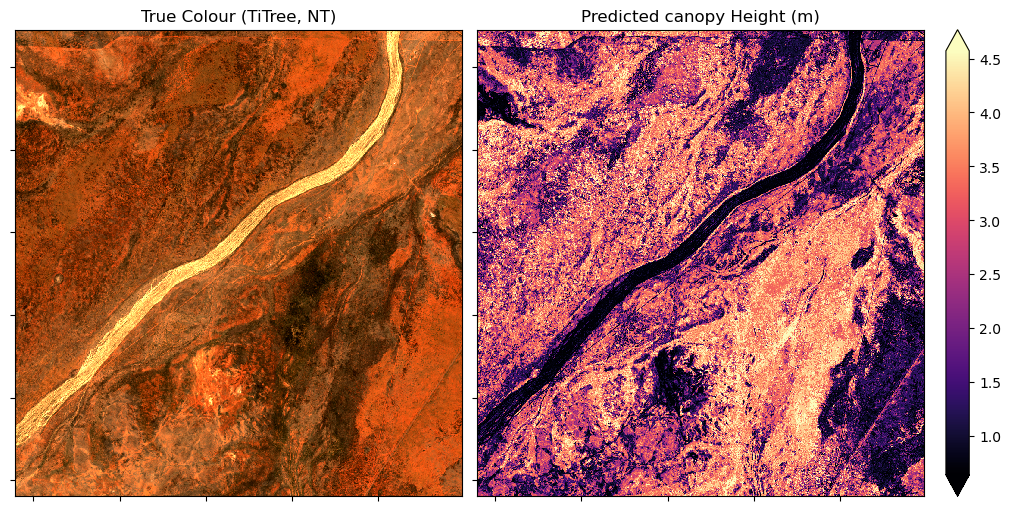

In [21]:
fig,ax=plt.subplots(1,2, figsize=(10,5), sharey=True, layout='constrained')
s2_gm[['nbart_red', 'nbart_green', 'nbart_blue']].to_array().plot.imshow(ax=ax[0], robust=True, add_labels=False)
y_pred_xr['Predictions'].plot.imshow(ax=ax[1], robust=True, cmap='magma', add_labels=False)
ax[0].set_title('True Colour (TiTree, NT)')
ax[1].set_title('Predicted canopy Height (m)')
ax[0].set_yticklabels([])
ax[0].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].set_xticklabels([]);